In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

import matplotlib.pyplot as plt
from pdpbox import pdp, get_example, info_plots

import torch
from torch import nn
import nn_functions as nnf
from sklearn.preprocessing import StandardScaler

## Dataset

The dataset I have chosen is the "Spaceship Titanic" from Kaggle: https://www.kaggle.com/competitions/spaceship-titanic/data. Different features are used to predict the probability of a passenger being transported to an alternate dimension.

In [4]:
spaceship = pd.read_csv("data/spaceship.csv")

spaceship = spaceship.dropna(axis=0)
spaceship["HomePlanetIsEarth"] = spaceship["HomePlanet"].map({"Europa":False, "Mars":False, "Earth":True})
spaceship["DestinationIsTrappist"] = spaceship["Destination"].map({"TRAPPIST-1e":True, "55 Cancri e":False, "PSO J318.5-22":False})
spaceship[["Deck", "Number", "Side"]] = spaceship["Cabin"].str.split("/", expand=True)
spaceship["CabinOnPort"] = spaceship["Side"].map({"P":True, "S":False})
X_spaceship = spaceship[["CryoSleep", "Age", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", 
                                  "VRDeck", "HomePlanetIsEarth", "DestinationIsTrappist", "CabinOnPort"]].reset_index(drop=True)
norm_X_spaceship = pd.DataFrame(StandardScaler().fit_transform(X_spaceship), columns=X_spaceship.columns)
all_features = list(norm_X_spaceship.columns)
X_spaceship = np.array(X_spaceship)
y_spaceship = np.array(spaceship["Transported"])

In [5]:
all_features

['CryoSleep',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'HomePlanetIsEarth',
 'DestinationIsTrappist',
 'CabinOnPort']

In [501]:
X_spaceship

array([[False, 39.0, False, ..., False, True, True],
       [False, 24.0, False, ..., True, True, False],
       [False, 58.0, True, ..., False, True, False],
       ...,
       [False, 26.0, False, ..., True, True, False],
       [False, 32.0, False, ..., False, False, False],
       [False, 44.0, False, ..., False, True, False]], dtype=object)

In [502]:
y_spaceship

array([False,  True, False, ...,  True, False,  True])

## Model

I use a completely black box neural network for the model.

In [357]:
# very basic architecture, to create a black box model
class BasicNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(num_features, 10),
            nn.ReLU(),
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, num_classes),
        )
    
    def forward(self, X):
        return self.layer_stack(X)
    
    def predict_proba(self, X):
        # custom predict_proba function, for the PDP functions
        X = np.array(X)
        X = torch.from_numpy(X).type(torch.float32).to("cuda")
        logits = self.layer_stack(X)
        probs = torch.sigmoid(logits)
        return probs.detach().cpu().numpy()

Epoch: 1 |  Train loss: 0.621 |  Test loss: 0.621 |  Train accuracy: 72.20% |  Test accuracy: 72.54%
Epoch: 2 |  Train loss: 0.493 |  Test loss: 0.496 |  Train accuracy: 77.01% |  Test accuracy: 77.61%
Epoch: 4 |  Train loss: 0.444 |  Test loss: 0.449 |  Train accuracy: 79.71% |  Test accuracy: 79.20%
Epoch: 6 |  Train loss: 0.434 |  Test loss: 0.443 |  Train accuracy: 79.90% |  Test accuracy: 79.35%
Epoch: 8 |  Train loss: 0.428 |  Test loss: 0.433 |  Train accuracy: 79.58% |  Test accuracy: 79.27%
Epoch: 10 |  Train loss: 0.425 |  Test loss: 0.425 |  Train accuracy: 79.64% |  Test accuracy: 79.35%
Epoch: 12 |  Train loss: 0.422 |  Test loss: 0.426 |  Train accuracy: 80.15% |  Test accuracy: 80.11%
Epoch: 14 |  Train loss: 0.418 |  Test loss: 0.424 |  Train accuracy: 80.13% |  Test accuracy: 79.65%
Epoch: 16 |  Train loss: 0.415 |  Test loss: 0.421 |  Train accuracy: 80.07% |  Test accuracy: 80.03%
Epoch: 18 |  Train loss: 0.412 |  Test loss: 0.423 |  Train accuracy: 80.32% |  Test ac

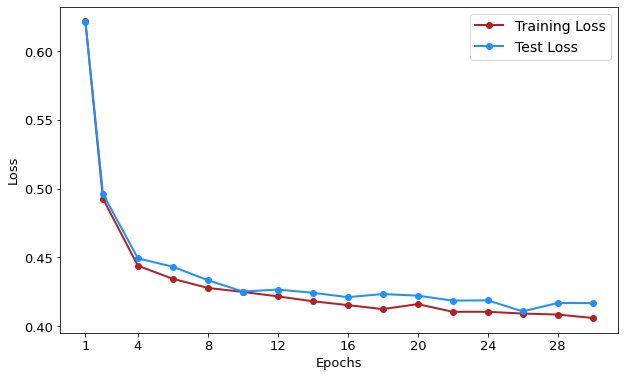

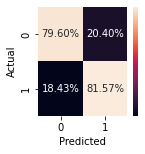

In [188]:
# test the accuracy of the model
torch.manual_seed(47)
basic_model = BasicNN(num_features=X_spaceship.shape[1], 
                      num_classes=1)
result_model = nnf.train_classification(basic_model, 
                                        X_data=X_spaceship, 
                                        y_data=y_spaceship, 
                                        batch_size=128,
                                        optimiser="Adam",
                                        lr=0.001,
                                        epochs=30)
nnf.predict_classification(result_model, StandardScaler().fit_transform(X_spaceship), y_spaceship)

In [358]:
# Train a final model using all of the training data
torch.manual_seed(47)
basic_model = BasicNN(num_features=X_spaceship.shape[1], 
                      num_classes=1)
final_model = nnf.train_final_model(basic_model, 
                                    X_data=X_spaceship, 
                                    y_data=y_spaceship, 
                                    batch_size=128,
                                    optimiser="Adam",
                                    lr=0.001,
                                    epochs=30)

Final training data loss: 0.404 |  Final training data accuracy: 80.94%


## Partial dependency plots

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

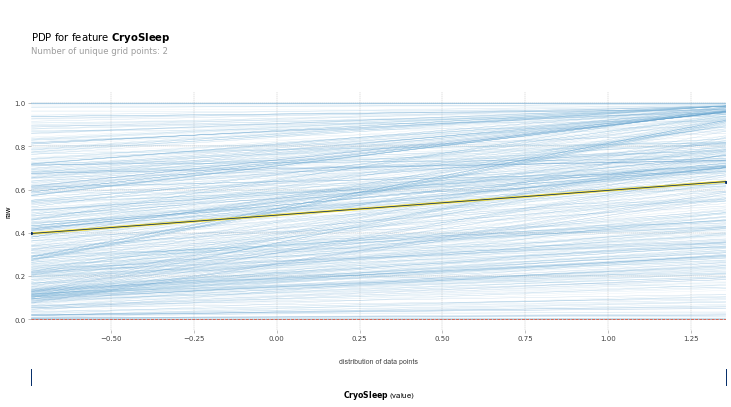

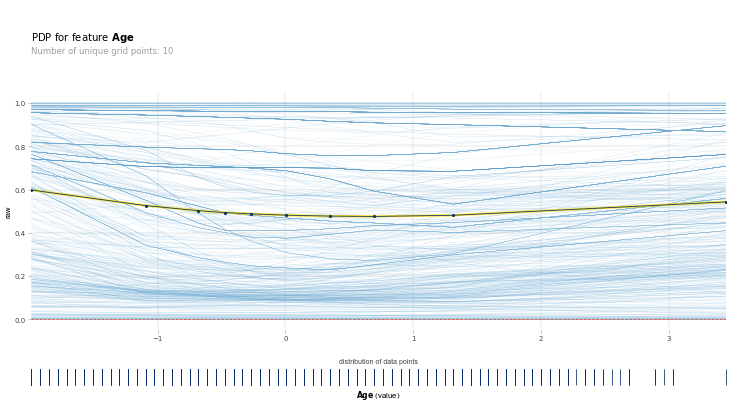

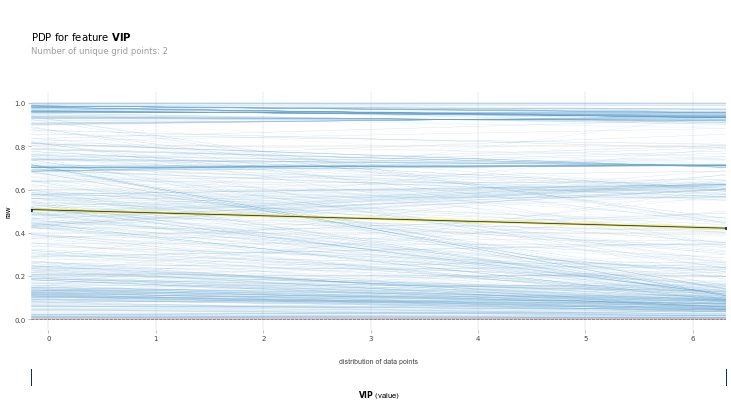

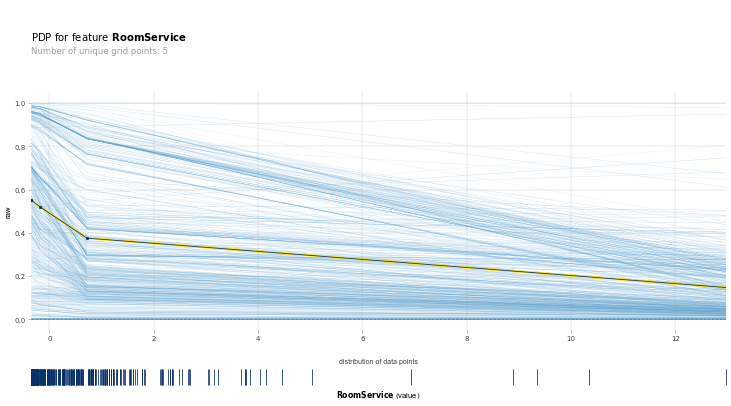

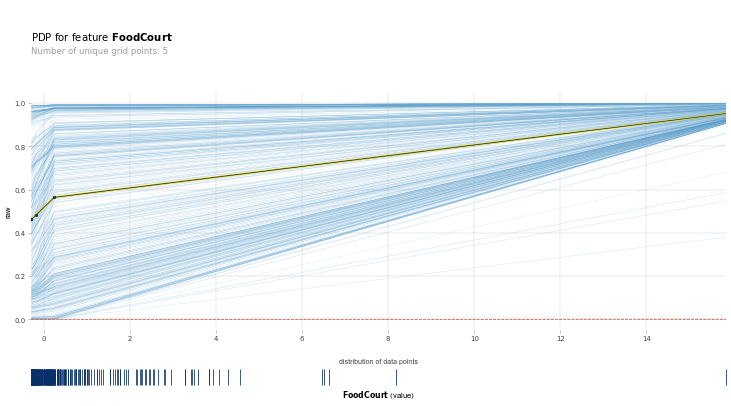

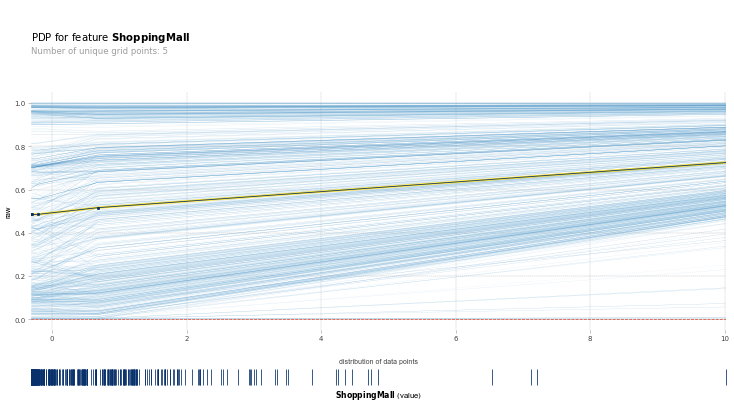

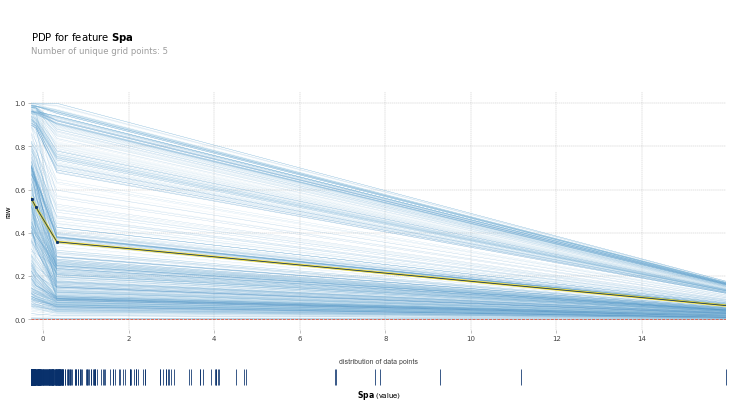

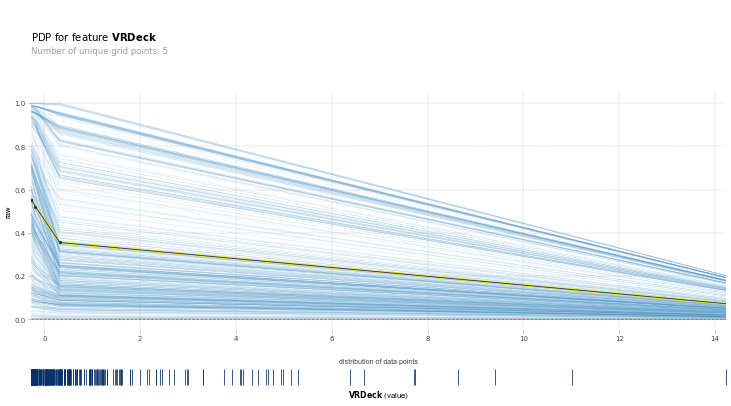

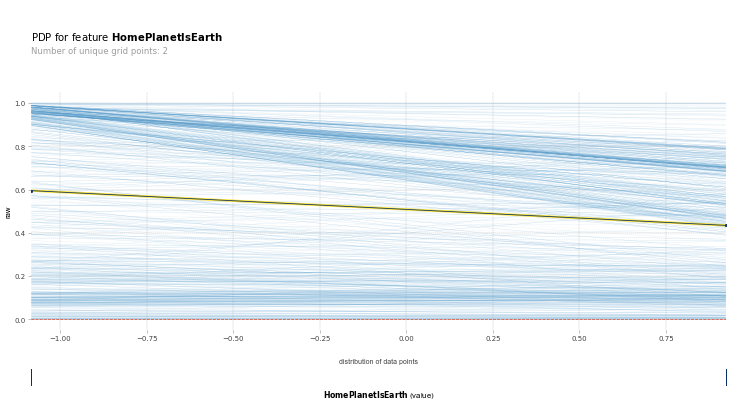

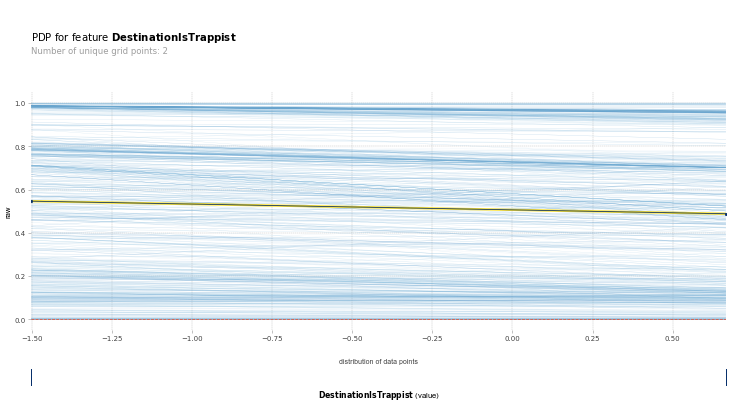

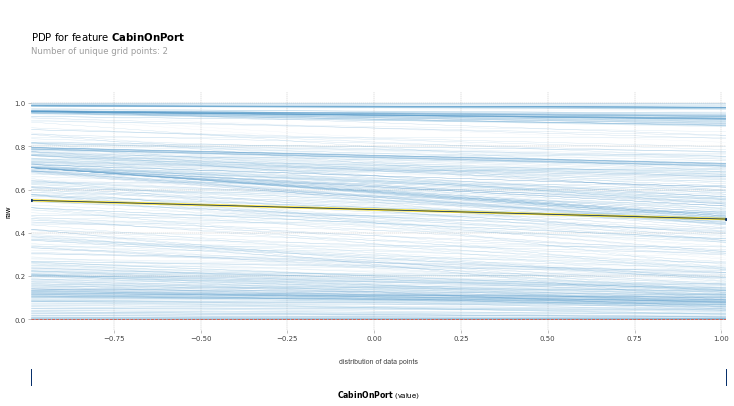

In [457]:
for feature in all_features:
    
    pdp_dist = pdp.PDPIsolate(model=final_model, 
                              df=norm_X_spaceship, 
                              model_features=all_features,
                              feature=feature,
                              feature_name=feature,
                              n_classes=0);

    fig, axes = pdp_dist.plot(
        center=False,
        frac_to_plot=0.1, # only plot 10% of the data, else the plot is too crowded to read
        plot_lines=True, # this also plots the ICE lines
        plot_pts_dist=True, # plot the distribution of the original points, to see where the model extrapolates
        plot_params={"pdp_hl": True}, # include the PDP average line
        dpi=56,
        engine="matplotlib",
        );
    fig.show()

Looking at the PDP lines only, the associations between each feature and the probability of a passenger being transported is as follows:

* Cryosleep: Positive association
* Age: Non-linear association, the probability is highest for very young and very old ages, and lowest in the middle.
* VIP: Negative association
* Room service: Negative association
* Food court: Positive association
* Shopping Mall: Positive association
* Spa: Negative association
* VRDeck: Negative association
* HomePlanetIsEarth: Negative to no association
* DestinationIsTrappist: Negative to no association
* CabinOnPort: Negative to no association

However, for many of the features, there is a high level of extrapolation outside of the majority of the datapoints. For example, the strong association on the rightside of the plots of Spa, Shopping mall and Food court, are influenced by just a few datapoints.

## Centered ICE plots

As it is very difficult to see the patterns of the individual ICE lines when all of the lines have different starting points, in the following plots, the lines will be centred, and thus the patterns can be analysed more easily:

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

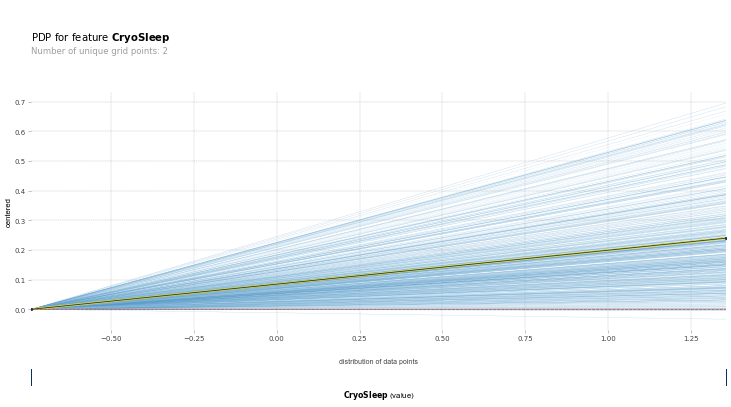

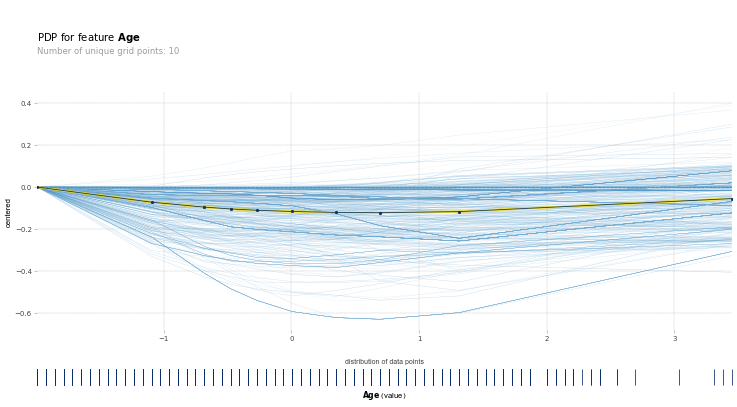

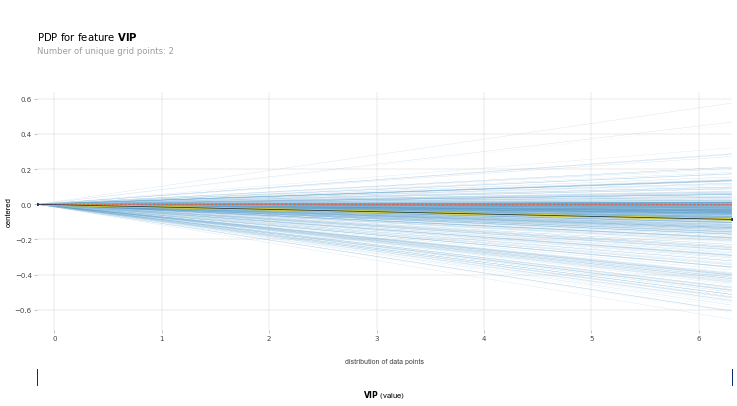

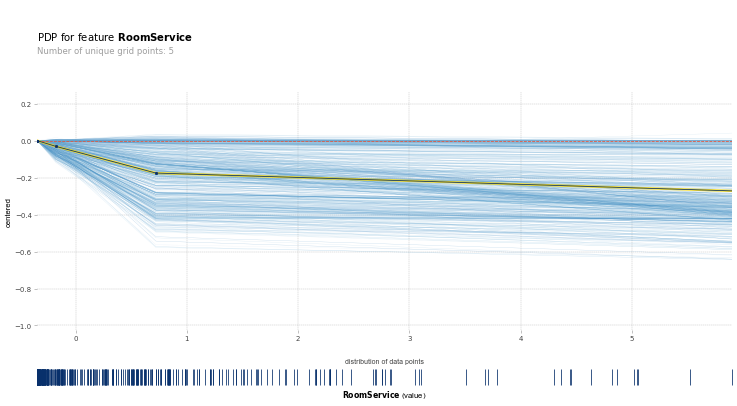

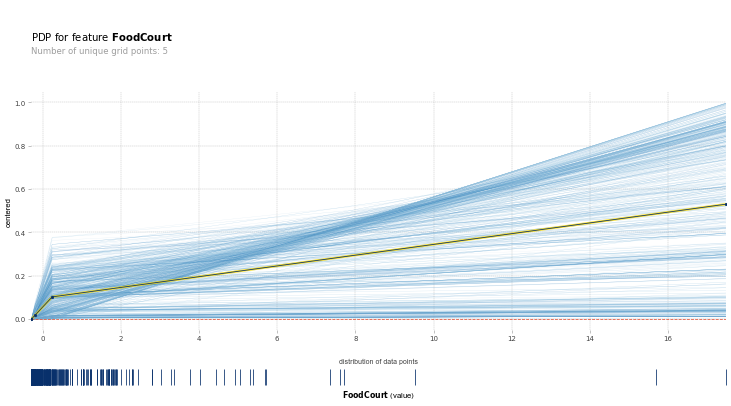

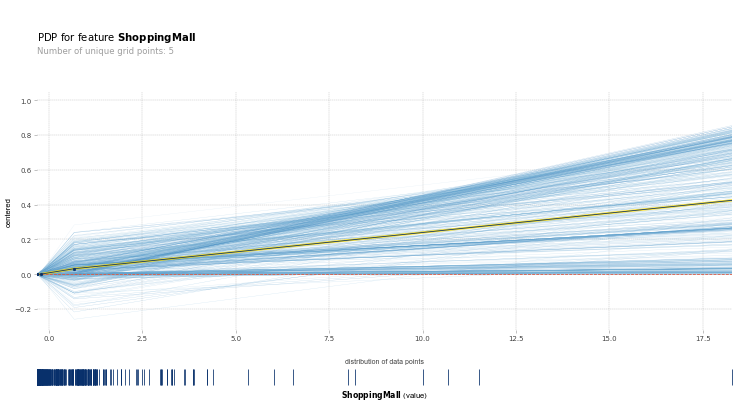

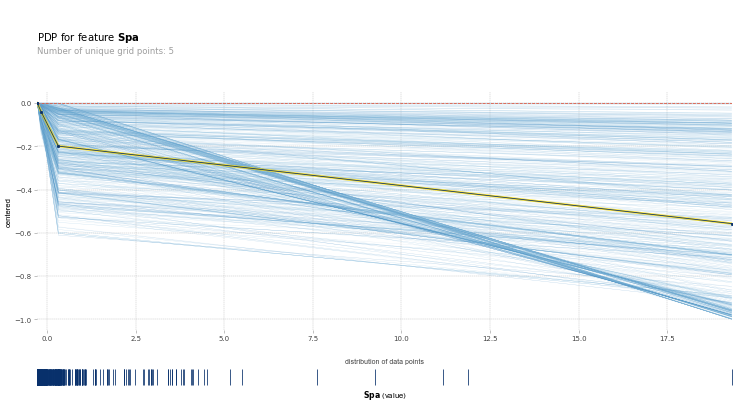

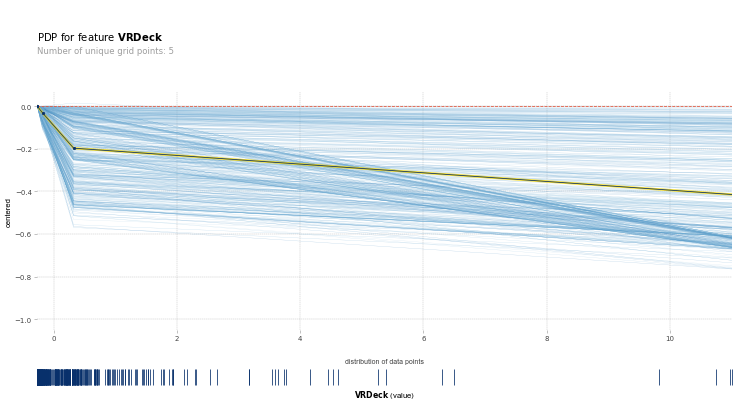

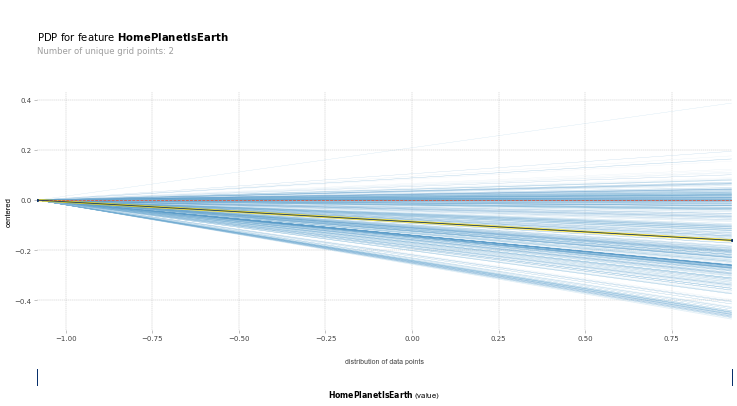

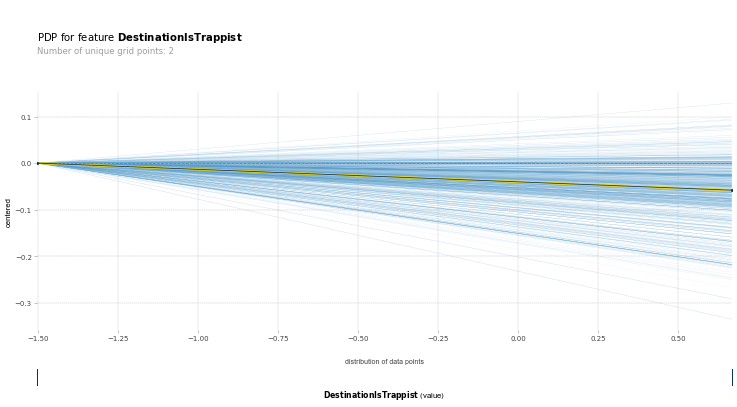

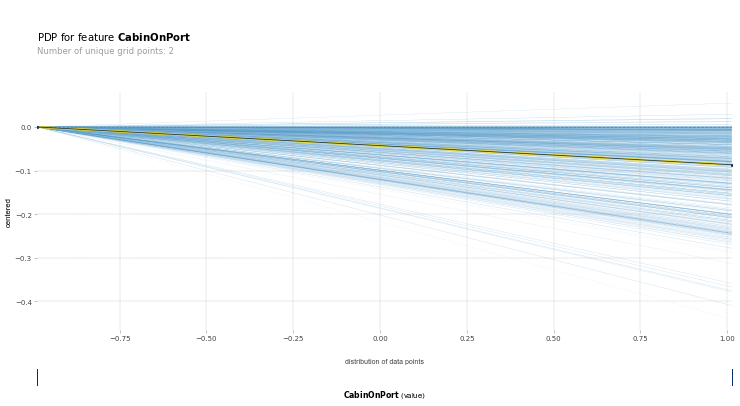

In [450]:
for feature in all_features:
    
    pdp_dist = pdp.PDPIsolate(model=final_model, 
                              df=norm_X_spaceship, 
                              model_features=all_features,
                              feature=feature,
                              feature_name=feature,
                              n_classes=0);

    fig, axes = pdp_dist.plot(
        center=True,
        frac_to_plot=0.1,
        plot_lines=True,
        plot_pts_dist=True,
        plot_params={"pdp_hl": True},
        dpi=56,
        engine='matplotlib',
        );

Each feature's impact to the prediction of whether a passenger will be transported:  
* *Cryosleep* - The PDP line has a positive gradient, thus if a passenger was put in cryosleep, then the model predicts they have a higher probability of being transported. Some of the ICE lines have different levels of steepness (although all are positive) suggesting the strength of this association differs due to other factors.
* ***Age* - The PDP line has a slight u curve, suggesting passengers are more likely to be transported if they are very young or very old. The ICE lines again all generally follow the same pattern, although with different strengths of gradient. However, a lines differed from the PDP pattern, where age was positively associated with probability of transporation - this should be investigated further.**
* ***VIP* - Although the PDP line appears to be very straight, suggesting no association, the ICE lines reveal that for some passengers, there is a strong positive association between being VIP and being transported, whereas for other passengers, there is a strong negative association. This is clear evidence of heterogeneous effects, and the 2D plots can thus be used to investigate for interactions of VIP with other features.**
* *Room service, Spa, and VR deck* - all depict similar relationships - a strong decrease in the model's prediction of the probability of being transported, when these feature values increase by about 1 (normalised), and then the probability plateauing/more slowly decreasing afterwards. The data distributions indicate that the strong decrease occurs in an area of the feature within which the model has a lot of data, whereas the rest of the pattern is being highly extrapolated. The divergence of some lines from the PDP line also only occurs in areas where there are very little data points. Therefore a strong decrease is the most reliable explanation. 
* ***Shopping mall* - this feature, when examined within the range of the majority of data points, shows a heterogeneous effect, where for some individuals, spending more at the shopping mall increases the probability of transportation, and for others, it decreases it. This should therefore also be investigated.**
* *HomePlanetIsEarth, DestinationIsTrappist and CabinOnPort* - all are slightly negatively associated with the probability of being transported. Some of the individual lines show a variation in the strength of this association. In general though, it appears that this feature has little impact on the prediction.

## 2D partial dependency plots

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/20 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/20 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/50 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/50 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/50 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/50 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/50 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/20 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/20 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/20 [00:00<?, ?it/s]

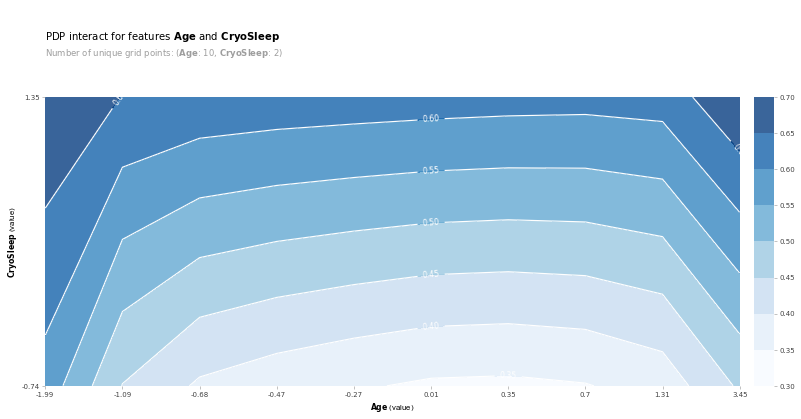

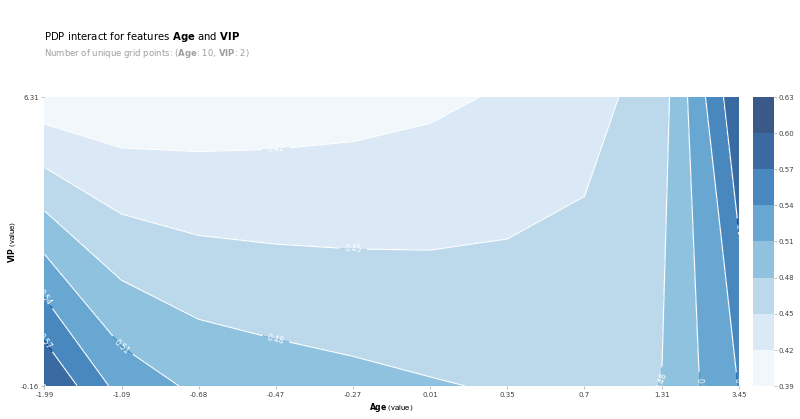

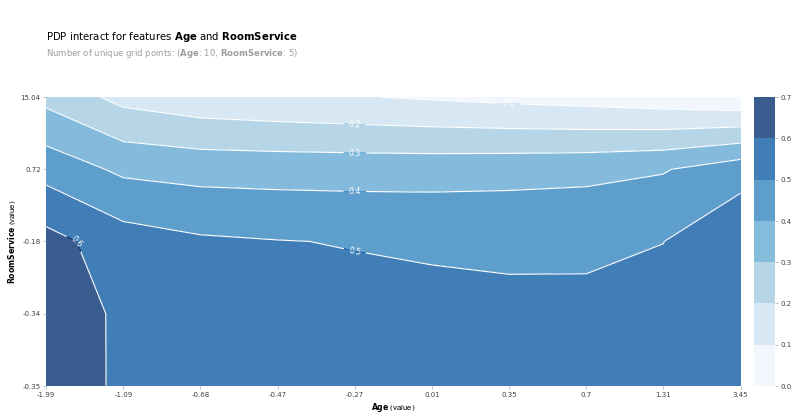

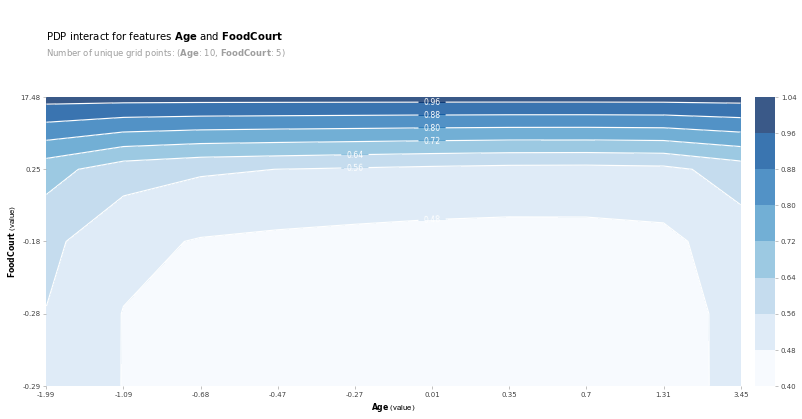

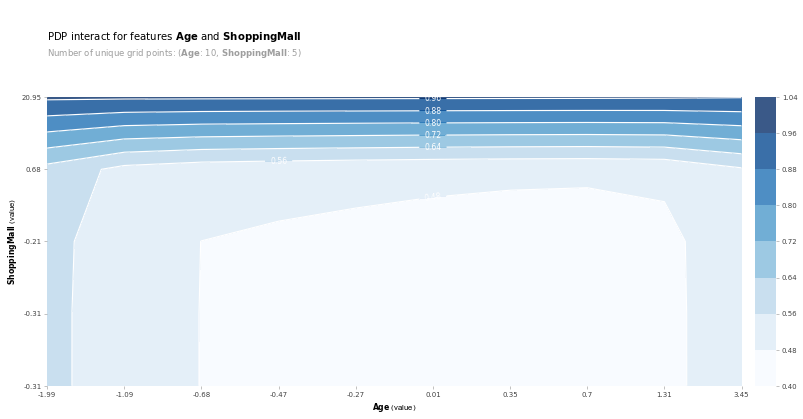

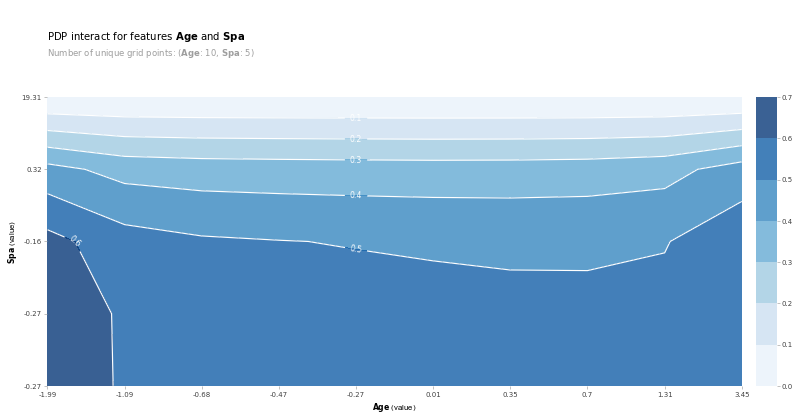

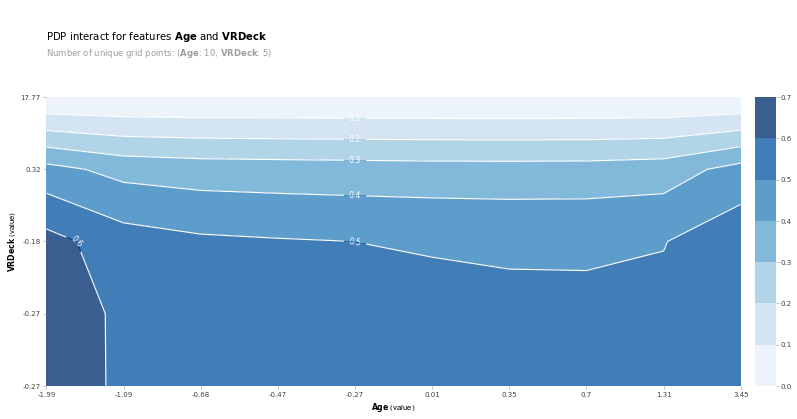

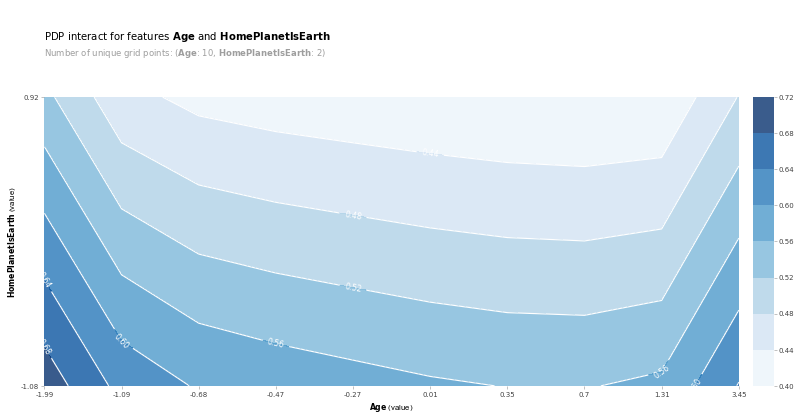

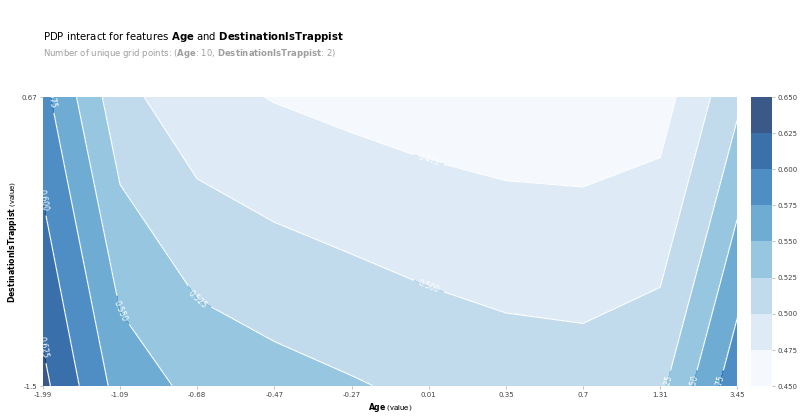

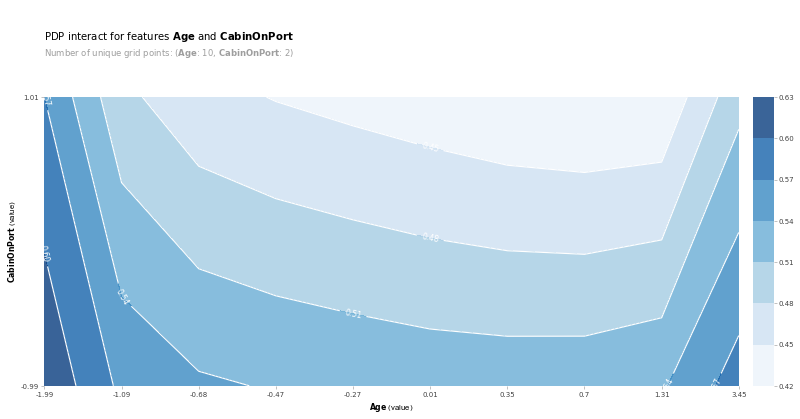

In [504]:
# Creating 2d dependency plots for the given feature, against all other features
feature_of_interest = "Age"
not_vip = [feature for feature in all_features if feature != feature_of_interest]
for feature_2 in not_vip:
    
    pdp_dist = pdp.PDPInteract(model=final_model, 
                              df=norm_X_spaceship, 
                              model_features=all_features,
                              features=[feature_of_interest, feature_2],
                              feature_names=[feature_of_interest, feature_2],
                              n_classes=0);
    
    fig, axes = pdp_dist.plot(
        dpi=56,
        engine="matplotlib",
    );

Description of interactions:
* If put in cryosleep, age doesn't have much influence on the probability for transportation. If not put in cryosleep, then we see the same pattern for age as in the PDP
* If VIP=1, then, increasing age increases the probability of transporation. Else we see the original pattern.
* Room service, food court, and shopping mall, spa and VR deck,  all have a much stronger influence on transporation probability than age does - the influence of age almost disappears. Only at low amounts of spending, do we see the pattern for age, as in the PDP. At high spending amounts, age is irrelevant. It is possible that age was correlated to these factors.
* For HomePlanetIsEarth, DestinationIsTrappist, and CabinOnPort, we see the same patterns. At positive values of these features, there is a stronger negative association between age and probability of transportatiob.

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/4 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/20 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/4 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/4 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/4 [00:00<?, ?it/s]

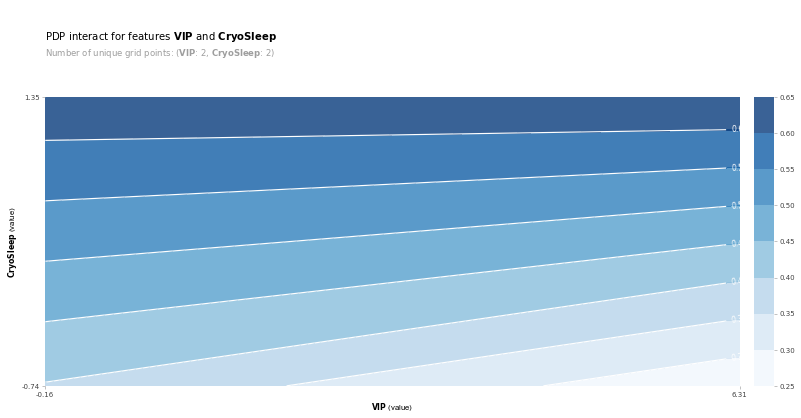

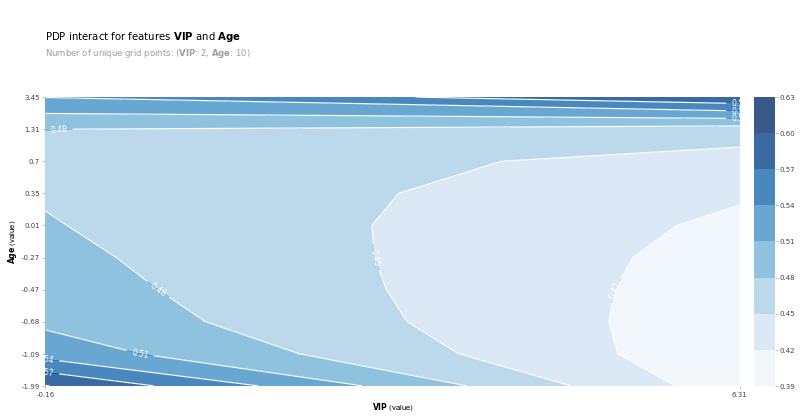

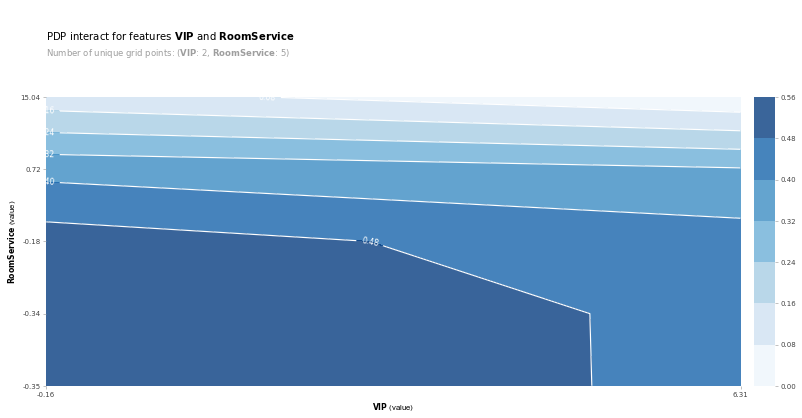

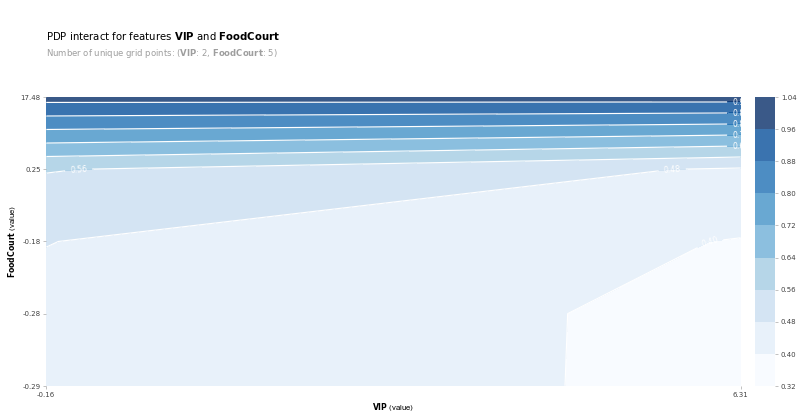

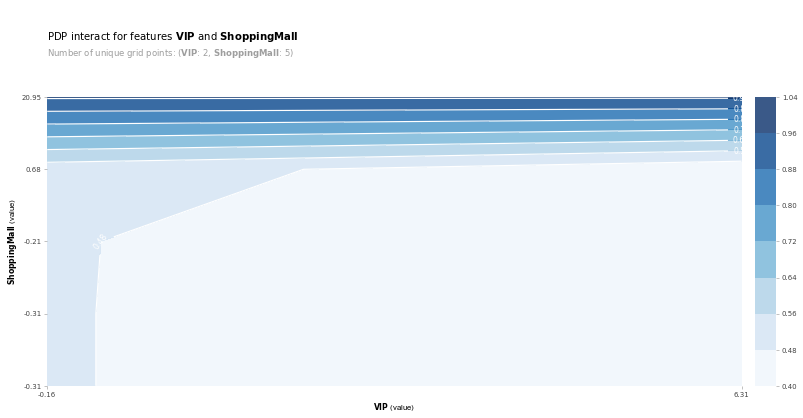

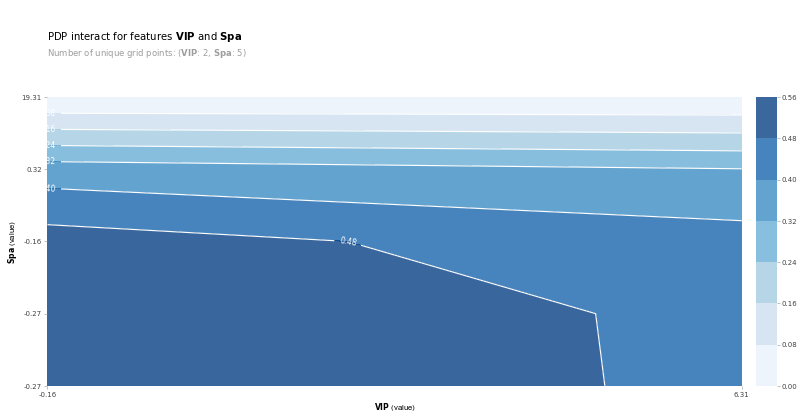

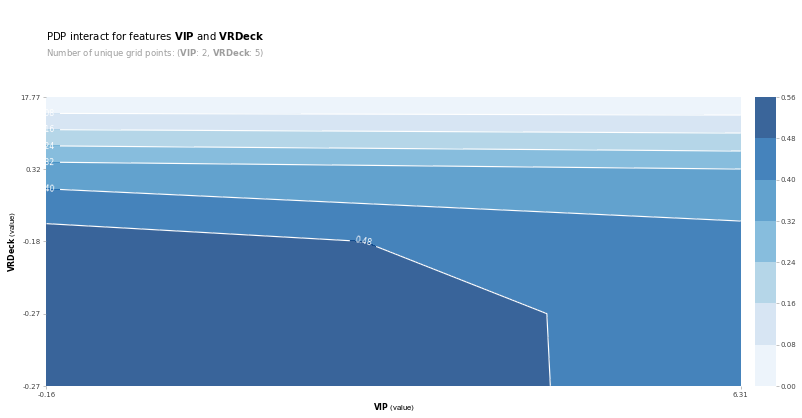

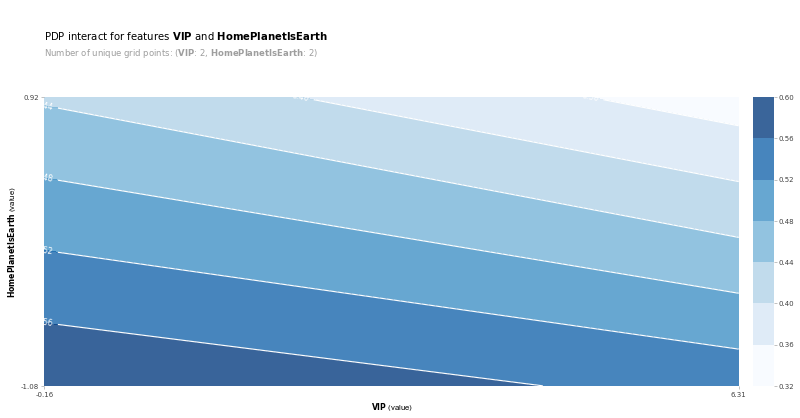

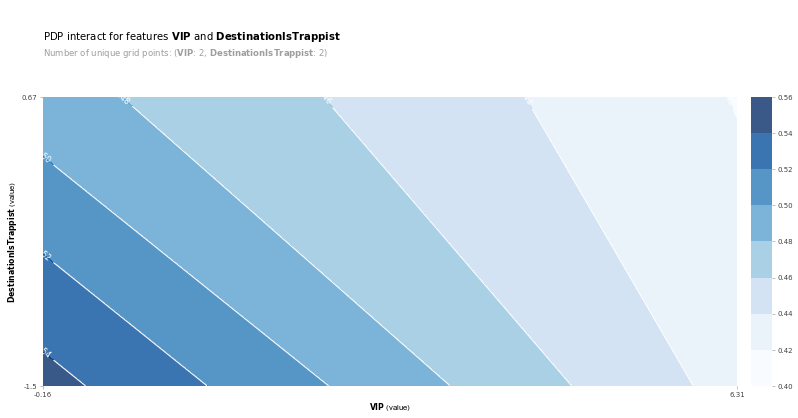

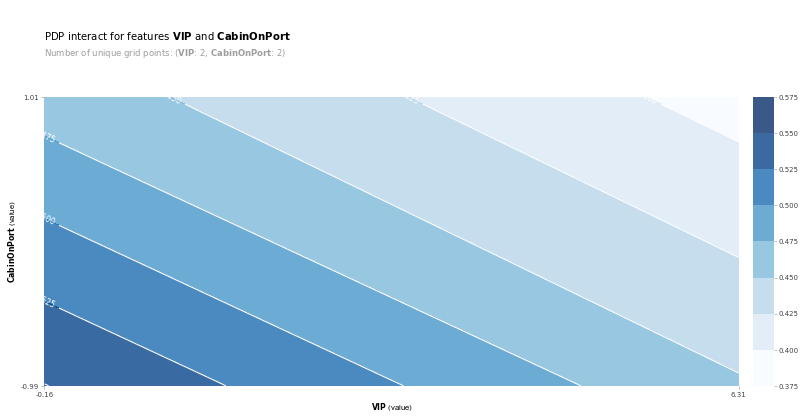

In [496]:
feature_of_interest = "VIP"
not_vip = [feature for feature in all_features if feature != feature_of_interest]
for feature_2 in not_vip:
    
    pdp_dist = pdp.PDPInteract(model=final_model, 
                              df=norm_X_spaceship, 
                              model_features=all_features,
                              features=[feature_of_interest, feature_2],
                              feature_names=[feature_of_interest, feature_2],
                              n_classes=0);
    
    fig, axes = pdp_dist.plot(
        dpi=56,
        engine="matplotlib",
    );

* For most of the features, the association patterns are very similar, regardless of whether VIP is 0 or 1 - the direction of the association is the same, even though the strength of the association sometimes differs.
* However, If VIP = 1, then the destinations has no impact on the probability. If it is 0, then the destination decreases the probability of transportation.
* For VIPs, haveing a cabin on port side decreases the probability of transportation much more strongly that those with a cabin on starboard side.

We have not however seen the reason for the strong divergence of the ICE lines. This therefore may have occurred due a more complex 3 or 4 way interaction.

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/50 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/25 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/25 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/25 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/25 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/5 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

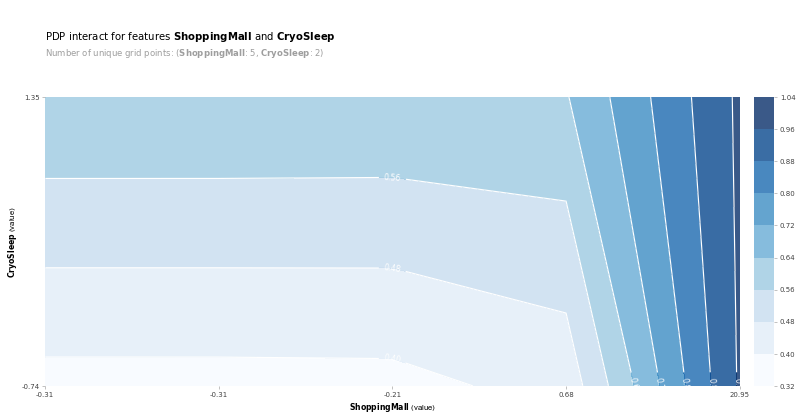

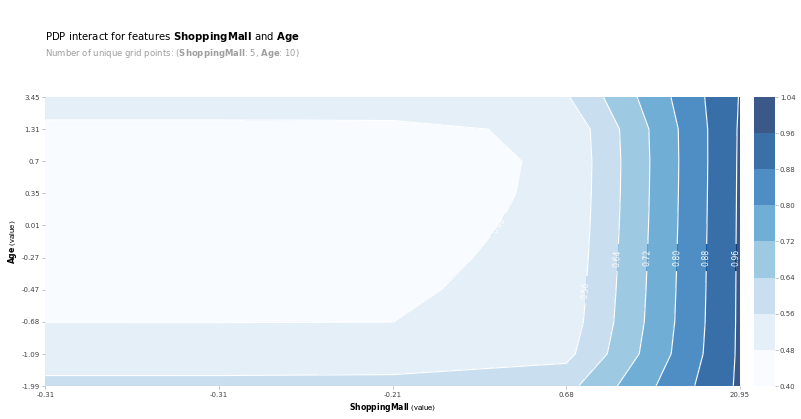

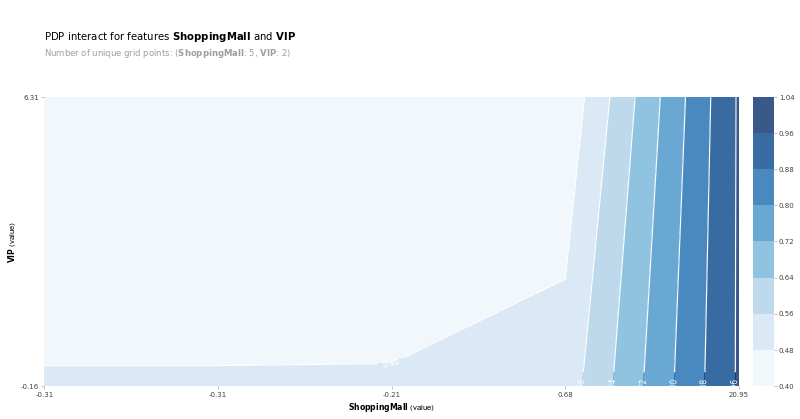

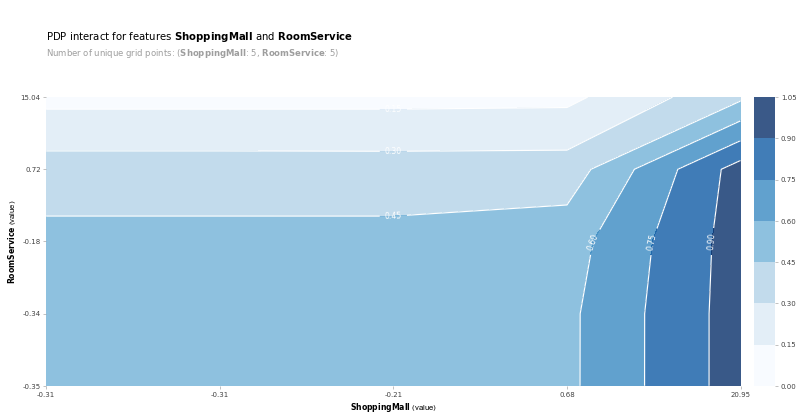

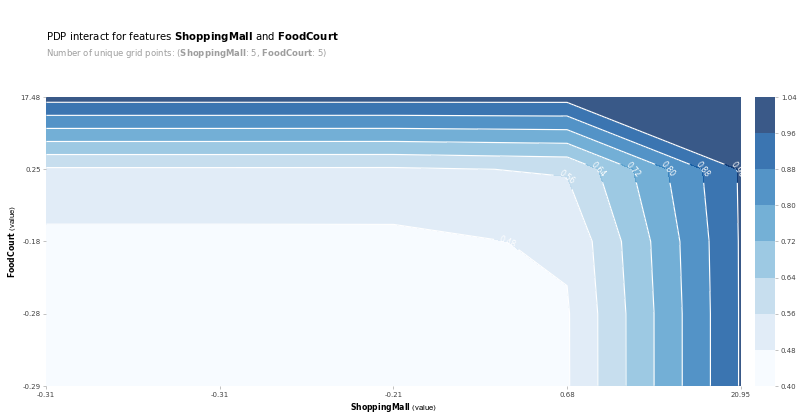

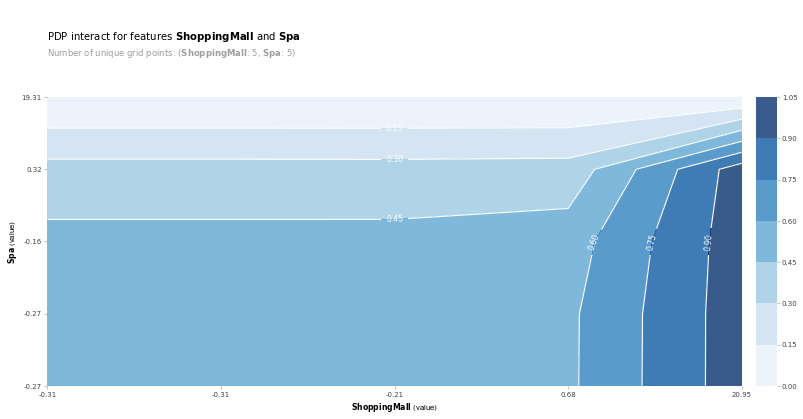

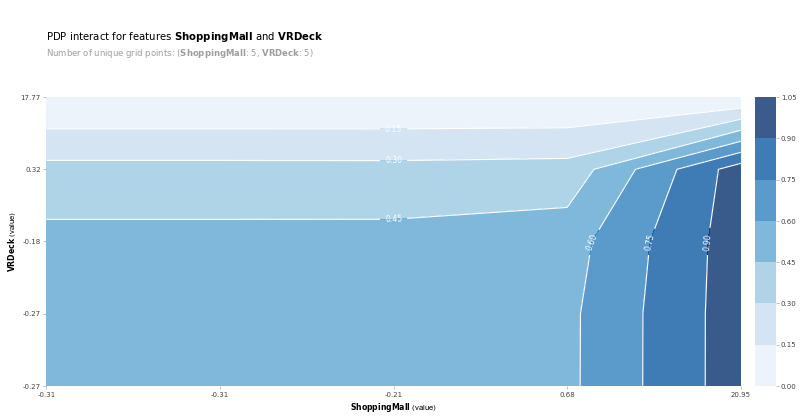

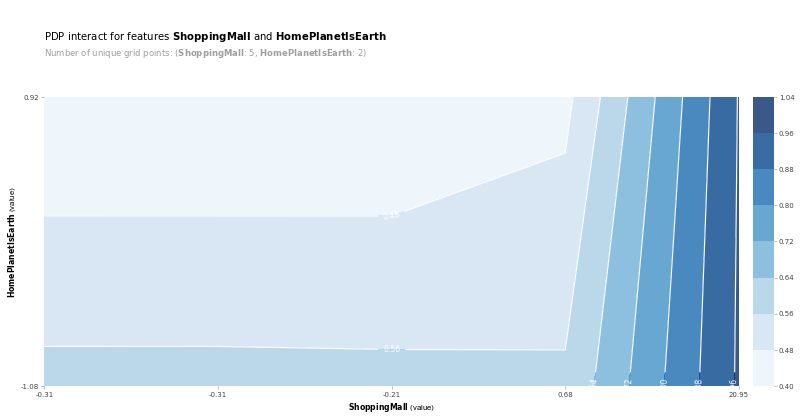

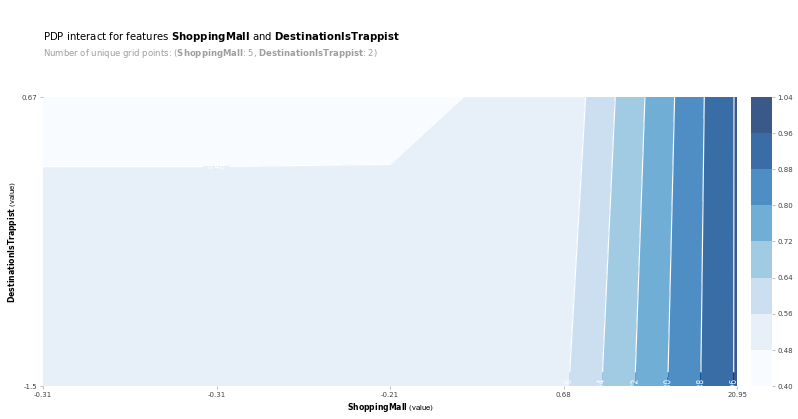

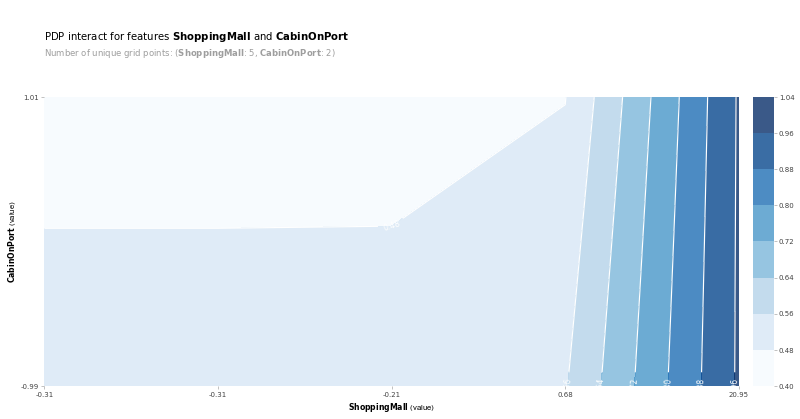

In [497]:
feature_of_interest = "ShoppingMall"
not_vip = [feature for feature in all_features if feature != feature_of_interest]
for feature_2 in not_vip:
    
    pdp_dist = pdp.PDPInteract(model=final_model, 
                              df=norm_X_spaceship, 
                              model_features=all_features,
                              features=[feature_of_interest, feature_2],
                              feature_names=[feature_of_interest, feature_2],
                              n_classes=0);
    
    fig, axes = pdp_dist.plot(
        dpi=56,
        engine="matplotlib",
    );

* For most of the features, they only have an influence on the probability of transportation at very low values of shopping mall spending. At high value sof shopping mall, it has a strong positive association, that dominates the influence of the other features.
* However, very high values of spa/vrdeck/roomservice, and high values of shopping mall, are associated with low probabilities of transporation, in a reversal of the usual patten. This is likely what has caused the discrepancy.

## Explanation Summary

* Being in cryosleep has a strong positive association with the model's predicted probability of being transported. If a passenger is put into cryosleep, then age has little to no influence on transportation; otherwise, younger and older ages have higher probabilities of transportation.

* Being a VIP passenger slightly reduces the predicted probability of being transported, although there are some heterogenous effects. If a passenger is VIP, then age is consistently positively associated with increased transportation probabilities.

* VR Deck, Spa and Room Service spending has a strong negative association with the probability of being transported, whereas shopping mall spending has a strong positive association with the probability of being transported. However, very high values of both spa/vrdeck/roomservice and high values of shopping mall, are unsually associated with low probabilities of transporation.

* One big issue with plots is correlations between the features; e.g. a person who is in cryosleep should not be able to be spending money on any of the ship's services! However the PDP will create "Frankenstein" data rows that suggest just that.

*(The explanation is selective, with 3 core expanatory bullet points. It is contrastive - e.g. comparing a passenger who is/isn't in cryosleep, or a passenger who spends a lot/spends a little at the shopping mall. It highlights abnormal causes, such as the rare case of high spending on both shopping malls and spa/vr deck/room service. The associations are consistent across the model's predictions (probable), and when they are modified by an interaction with another feature, this has been described truthfully.)*